# Triple Barrier Method

This notebook will cover partial exercise answers:

* Exercise 3.5

As we go along, there will be some explanations.

More importantly, this method can be applied not just within mean-reversion strategy but also other strategies as well. 

Most of the functions below can be found under research/Labels.

In [1]:
import numpy as np
import pandas as pd
import research as rs
import matplotlib.pyplot as plt

%matplotlib inline

p = print

#pls take note of version
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

dollar = pd.read_csv('./research/Sample_data/dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])


Num of CPU core:  4
Machine info:  Windows-10-10.0.18362-SP0
Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy 1.17.3
Pandas 1.0.3


C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1500x800 with 1 Axes>

In [2]:
def bband(data: pd.DataFrame, window: int = 21, width: float = 0.001):
    avg = data['close'].ewm(span = window).mean()
    std = avg * width
    upper = avg + std
    lower = avg - std
    return avg, upper, lower, std

dollar['ewm'], dollar['upper'], dollar['lower'], dollar['std'] = bband(dollar)

# Check for normality, serial correlation, overall statistical properties, frequency count stability

In [3]:
dollar['side'] = np.nan

def side_pick(data: pd.DataFrame):
    for i in np.arange(data.index.shape[0]):
        if (data['close'].iloc[i] >= data['upper'].iloc[i]):
            data['side'].iat[i] = -1
        elif (data['close'].iloc[i] <= data['lower'].iloc[i]):
            data['side'].iat[i] = 1
    return data

upper = dollar[dollar['upper'] < dollar['close']] # short signal
lower = dollar[dollar['lower'] > dollar['close']] # long signal

p("Num of times upper limit touched: {0}\nNum of times lower limit touched: {1}"
  .format(upper.count()[0], 
          lower.count()[0]))

# Recall white test as a benchmark and until this stage we filtered all those which did not meet min return
dollar = side_pick(dollar)
dollar.dropna(inplace= True)
dollar['side'].value_counts()

Num of times upper limit touched: 8495
Num of times lower limit touched: 7811


-1.0    8495
 1.0    7811
Name: side, dtype: int64

In [4]:
copy_dollar = dollar.copy() # make a back copy to be used in later exercise

copy_dollar #up till this point the below dataframe should look like this, before tri_bar func. This is our primary model.

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,ewm,upper,lower,std,side
date_time,,,,,,,,,,,,
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514,2060.547619,2062.608167,2058.487071,2.060548,-1.0
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332,2061.404789,2063.466193,2059.343384,2.061405,-1.0
2015-01-02 14:33:39.311,2063.75,2064.75,2060.00,2064.50,33944,70001009.00,12846,2062.050864,2064.112915,2059.988814,2.062051,-1.0
2015-01-02 14:42:28.315,2064.50,2066.50,2063.25,2066.00,33901,70010093.25,13032,2062.788295,2064.851084,2060.725507,2.062788,-1.0
2015-01-02 15:01:45.497,2063.50,2064.00,2058.75,2058.75,34008,70122046.75,13873,2062.252963,2064.315216,2060.190710,2.062253,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 20:22:33.456,2231.25,2233.75,2231.00,2233.50,31355,70001983.50,2453,2237.134042,2239.371176,2234.896908,2.237134,1.0
2016-12-30 20:32:57.188,2233.50,2235.00,2232.50,2233.25,31349,70029302.00,2621,2236.780947,2239.017728,2234.544167,2.236781,1.0
2016-12-30 20:44:21.481,2233.25,2234.00,2230.50,2230.75,31362,70017565.50,2836,2236.232680,2238.468912,2233.996447,2.236233,1.0


In [5]:
d_vol = rs.vol(dollar['close'], span0 = 50)

In [6]:
events = rs.cs_filter(dollar['close'], 
                    limit = d_vol.mean())

events

DatetimeIndex(['2015-01-02 14:19:33.847000', '2015-01-02 14:33:39.311000',
               '2015-01-02 14:42:28.315000', '2015-01-02 15:01:45.497000',
               '2015-01-02 15:22:54.187000', '2015-01-02 15:32:59.861000',
               '2015-01-02 15:39:14.826000', '2015-01-02 15:43:25.099000',
               '2015-01-02 15:48:54.420000', '2015-01-02 15:57:26.907000',
               ...
               '2016-12-30 19:02:57.783000', '2016-12-30 19:29:47.411000',
               '2016-12-30 19:47:05.557000', '2016-12-30 19:55:31.030000',
               '2016-12-30 20:12:10.314000', '2016-12-30 20:22:33.456000',
               '2016-12-30 20:32:57.188000', '2016-12-30 20:44:21.481000',
               '2016-12-30 20:50:57.567000', '2016-12-30 20:55:33.160000'],
              dtype='datetime64[ns]', length=15459, freq=None)

In [7]:
vb = rs.vert_barrier(data = dollar['close'], 
                 events = events, 
                 period = 'days', 
                 freq = 1)

vb # Show some example output

2015-01-02 14:19:33.847   2015-01-04 23:20:12.567
2015-01-02 14:33:39.311   2015-01-04 23:20:12.567
2015-01-02 14:42:28.315   2015-01-04 23:20:12.567
2015-01-02 15:01:45.497   2015-01-04 23:20:12.567
2015-01-02 15:22:54.187   2015-01-04 23:20:12.567
                                    ...          
2016-12-29 16:18:10.918   2016-12-30 17:17:03.543
2016-12-29 16:43:29.395   2016-12-30 17:17:03.543
2016-12-29 17:03:04.248   2016-12-30 17:17:03.543
2016-12-29 17:17:04.110   2016-12-30 17:44:08.768
2016-12-29 18:58:02.400   2016-12-30 19:02:57.783
Name: date_time, Length: 15434, dtype: datetime64[ns]

In [8]:
tb = rs.tri_barrier(data = dollar['close'], 
                events = events, 
                trgt = d_vol, 
                min_req = 0.002, 
                num_threads = 3, 
                ptSl = [0,2], #change ptSl into [0,2]
                t1 = vb, 
                side = dollar['side'])

tb # Show some example

C:\Users\Wei_X\Desktop\Python\research\Labels\triple_barrier_method.py:75: UserWarning: Data and events index shape must be same, reindex data to fit events
  warnings.warn('Data and events index shape must be same, reindex data to fit events')


[                                             t1                      sl  pt
2015-01-05 14:54:26.286 2015-01-06 15:16:04.445 2015-01-05 16:15:59.512 NaT
2015-01-05 14:57:13.616 2015-01-06 15:16:04.445 2015-01-05 16:21:16.062 NaT
2015-01-05 15:01:57.494 2015-01-06 15:16:04.445 2015-01-05 17:32:22.888 NaT
2015-01-05 15:07:29.012 2015-01-06 15:16:04.445 2015-01-05 17:26:59.327 NaT
2015-01-05 15:13:09.655 2015-01-06 15:16:04.445 2015-01-05 17:32:22.888 NaT
...                                         ...                     ...  ..
2015-09-09 08:33:28.634 2015-09-10 09:33:29.450                     NaT NaT
2015-09-09 10:21:19.955 2015-09-10 11:43:14.539                     NaT NaT
2015-09-09 12:02:05.852 2015-09-10 12:19:25.229                     NaT NaT
2015-09-09 13:06:01.330 2015-09-10 13:30:20.359                     NaT NaT
2015-09-09 13:31:24.524 2015-09-10 13:35:08.110                     NaT NaT

[5142 rows x 3 columns]] this out
[                                             t1    

2020-05-24 19:47:10.493415 100.0% _pt_sl_t1 done after 0.38 minutes. Remaining 0.0 minutes.


,t1,trgt,side
2015-01-05 14:54:26.286,2015-01-05 16:15:59.512,0.002238,1.0
2015-01-05 14:57:13.616,2015-01-05 16:21:16.062,0.002462,1.0
2015-01-05 15:01:57.494,2015-01-05 17:32:22.888,0.002779,1.0
2015-01-05 15:07:29.012,2015-01-05 17:26:59.327,0.002819,1.0
2015-01-05 15:13:09.655,2015-01-05 17:32:22.888,0.002874,1.0
...,...,...,...
2016-12-29 16:18:10.918,2016-12-30 17:17:03.543,0.004250,1.0
2016-12-29 16:43:29.395,2016-12-30 17:17:03.543,0.004166,1.0
2016-12-29 17:03:04.248,2016-12-30 17:17:03.543,0.004090,1.0
2016-12-29 17:17:04.110,2016-12-30 17:44:08.768,0.004016,1.0


In [9]:
m_label = rs.meta_label(data = dollar['close'],
                      events = tb,
                      drop = False)

m_label # Show some example

,ret,bin,side
2015-01-05 14:54:26.286,-0.004556,0.0,1.0
2015-01-05 14:57:13.616,-0.005051,0.0,1.0
2015-01-05 15:01:57.494,-0.005798,0.0,1.0
2015-01-05 15:07:29.012,-0.005790,0.0,1.0
2015-01-05 15:13:09.655,-0.006656,0.0,1.0
...,...,...,...
2016-12-29 16:18:10.918,-0.001672,0.0,1.0
2016-12-29 16:43:29.395,-0.001894,0.0,1.0
2016-12-29 17:03:04.248,-0.001226,0.0,1.0
2016-12-29 17:17:04.110,-0.001450,0.0,1.0


In [10]:
m_label['bin'].value_counts(normalize=True)

# Here is a quick look at our 'bin' values.
# Slight imbalanced sample, but not much harm
# 51.95% of the sample based on parameter touched vertical barrier first

0.0    0.519545
1.0    0.480455
Name: bin, dtype: float64

* Exercise 3.5b

Here onwards we will be using sklearn modules to perform ML related task.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# A quick look at what we have till date using both primary and secondary model
# as seen in previous example, only 48.04% was labeled 1. 
# Hence precision 1.0 = 0.48 (48% of the sample is relevant), while recall = 1 means fully correct (based on the 48% sample)

The below function report_matrix is what we have till date using both primary (bband func) and secondary model (tri_bar func).

#### Classification Report

As seen in previous example, only 48.0455% was labeled 1. 

Hence precision 1.0 = 0.48 (48.0455% of the sample is relevant). It's basically ML's way of saying are these "features" relevant when tested.

While recall = 1 means fully correct (based on the 48% sample). In the case where ML model is fitted, this result will mean the percentage of "correct" label was chosen. In short, is the ML model reliability in True positive identification based on given sample.

#### Confusion Matrix

8001 = False Positive (51.95%)
7399 = True Positive (48.0455%)

#### Accuracy Score

Is a mere reflection of True Positive, which again is 48.0455%

In [12]:
# this func can be found under Tools/stats_rpt

forecast = rs.report_matrix(actual_data = m_label, 
                            prediction_data = None,
                            ROC = None)

 Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      8001
         1.0       0.48      1.00      0.65      7399

    accuracy                           0.48     15400
   macro avg       0.24      0.50      0.32     15400
weighted avg       0.23      0.48      0.31     15400


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[   0 8001]
 [   0 7399]]

 Accuracy Score
0.48045454545454547



C:\Users\Wei_X\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Built a list of features.

1. Volatility
2. Autocorrelation
3. Moving average
4. log-price return (optional)
5. Stationary series based on cumulative sum log-price return (optional)

The last 2 items will be explained at AFML chapter 5, fractional differentiated features.

In [13]:
# Data that was copied earlier before tri_bar func, this is our primary model only

copy_dollar # Show example

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,ewm,upper,lower,std,side
date_time,,,,,,,,,,,,
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514,2060.547619,2062.608167,2058.487071,2.060548,-1.0
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332,2061.404789,2063.466193,2059.343384,2.061405,-1.0
2015-01-02 14:33:39.311,2063.75,2064.75,2060.00,2064.50,33944,70001009.00,12846,2062.050864,2064.112915,2059.988814,2.062051,-1.0
2015-01-02 14:42:28.315,2064.50,2066.50,2063.25,2066.00,33901,70010093.25,13032,2062.788295,2064.851084,2060.725507,2.062788,-1.0
2015-01-02 15:01:45.497,2063.50,2064.00,2058.75,2058.75,34008,70122046.75,13873,2062.252963,2064.315216,2060.190710,2.062253,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 20:22:33.456,2231.25,2233.75,2231.00,2233.50,31355,70001983.50,2453,2237.134042,2239.371176,2234.896908,2.237134,1.0
2016-12-30 20:32:57.188,2233.50,2235.00,2232.50,2233.25,31349,70029302.00,2621,2236.780947,2239.017728,2234.544167,2.236781,1.0
2016-12-30 20:44:21.481,2233.25,2234.00,2230.50,2230.75,31362,70017565.50,2836,2236.232680,2238.468912,2233.996447,2.236233,1.0


In [14]:
# drop redundant columns and keep crossing moving avaerages
pri_dollar = copy_dollar.drop(['open', 'high', 'low', 'cum_vol', 'cum_dollar', 'cum_ticks'], axis = 1)

#include volatility, autocorrelation
pri_dollar

,close,ewm,upper,lower,std,side
date_time,,,,,,
2015-01-02 07:07:35.156,2064.00,2060.547619,2062.608167,2058.487071,2.060548,-1.0
2015-01-02 14:19:33.847,2063.75,2061.404789,2063.466193,2059.343384,2.061405,-1.0
2015-01-02 14:33:39.311,2064.50,2062.050864,2064.112915,2059.988814,2.062051,-1.0
2015-01-02 14:42:28.315,2066.00,2062.788295,2064.851084,2060.725507,2.062788,-1.0
2015-01-02 15:01:45.497,2058.75,2062.252963,2064.315216,2060.190710,2.062253,1.0
...,...,...,...,...,...,...
2016-12-30 20:22:33.456,2233.50,2237.134042,2239.371176,2234.896908,2.237134,1.0
2016-12-30 20:32:57.188,2233.25,2236.780947,2239.017728,2234.544167,2.236781,1.0
2016-12-30 20:44:21.481,2230.75,2236.232680,2238.468912,2233.996447,2.236233,1.0


In [15]:
#include original volatility
pri_dollar['volatility'] = rs.vol(pri_dollar.close, span0 = 50)

In [16]:
# Optional: getting stationarity feature
pri_dollar['log_price'] = pri_dollar.close.apply(np.log)
pri_dollar['log_return'] = pri_dollar.log_price.diff()

cs_log = pri_dollar.log_price.diff().dropna().to_frame()
pri_dollar['stationary'] = rs.fracDiff_FFD(data = cs_log, d = 1.99999889 , thres = 1e-5)

rs.unit_root(pri_dollar['stationary'].dropna()) #check for stationarity

C:\Users\Wei_X\Desktop\Python\research\Features\fractional_diff.py:93: UserWarning: thres val <= 1.e-2 may not suit non-trend series, may take up longer than expected to calculate val i.e. 1e-5
  warnings.warn('thres val <= 1.e-2 may not suit non-trend series, may take up longer than expected to calculate val i.e. 1e-5')



ADF & KPSS: Weak evidence for stationary



C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [17]:
pri_dollar.dropna(inplace = True)

In [18]:
# autocorrelation residual feature, we will add AR features up to 2 lags
from statsmodels.tsa.arima_model import ARMA

pri_dollar['ar_0'] = ARMA(pri_dollar['stationary'], order=(0,0)).fit().resid
pri_dollar['ar_1'] = ARMA(pri_dollar['stationary'], order=(1,0)).fit().resid
pri_dollar['ar_2'] = ARMA(pri_dollar['stationary'], order=(2,0)).fit().resid

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. foreca

In [19]:
#final dataset

secondary_dollar = pri_dollar.copy()

**Note

* Good to include volume based or volume-weighted indicator as a predictive feature i.e. OBV, VWAP

**Note**

May try to add other types of trend related features as part of experimental Mathematics. (aka Trial & error)

* Good to include volume based or volume-weighted indicator as a predictive feature i.e. OBV, VWAP
* If not, try to add price based as predictive feature i.e. MOM, RSI

In [20]:
# Now we run all the steps to complete labels, to train random forest.
# we will use both primary & secondary model

events0 = rs.cs_filter(secondary_dollar['close'], 
                    limit = secondary_dollar['volatility'].mean())

vb0 = rs.vert_barrier(data = secondary_dollar['close'], 
                 events = events0, 
                 period = 'days', 
                 freq = 1)

tb0 = rs.tri_barrier(data = secondary_dollar['close'], 
                events = events0, 
                trgt = secondary_dollar['volatility'], 
                min_req = 0.002, 
                num_threads = 3, 
                ptSl = [0,2], #change ptSl into [0,2]
                t1 = vb0, 
                side = secondary_dollar['side'])

m_label0 = rs.meta_label(data = secondary_dollar['close'],
                      events = tb0,
                      drop = 0.05)

m_label0

C:\Users\Wei_X\Desktop\Python\research\Labels\triple_barrier_method.py:75: UserWarning: Data and events index shape must be same, reindex data to fit events
  warnings.warn('Data and events index shape must be same, reindex data to fit events')


[                                             t1  sl  pt
2015-09-09 13:36:53.472 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:40:56.133 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:45:08.189 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:51:11.450 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 14:02:04.210 2015-09-10 14:05:19.003 NaT NaT
...                                         ...  ..  ..
2016-04-05 01:16:26.261 2016-04-06 02:45:07.823 NaT NaT
2016-04-05 06:02:04.305 2016-04-06 07:07:24.337 NaT NaT
2016-04-05 07:11:07.085 2016-04-06 08:05:23.022 NaT NaT
2016-04-05 07:37:56.273 2016-04-06 08:05:23.022 NaT NaT
2016-04-05 08:24:13.547 2016-04-06 09:05:34.702 NaT NaT

[5142 rows x 3 columns]] this out
[                                             t1  sl  pt
2015-09-09 13:36:53.472 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:40:56.133 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:45:08.189 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:51:11.450 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 

[                                             t1  sl  pt
2015-09-09 13:36:53.472 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:40:56.133 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:45:08.189 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:51:11.450 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 14:02:04.210 2015-09-10 14:05:19.003 NaT NaT
...                                         ...  ..  ..
2016-04-05 01:16:26.261 2016-04-06 02:45:07.823 NaT NaT
2016-04-05 06:02:04.305 2016-04-06 07:07:24.337 NaT NaT
2016-04-05 07:11:07.085 2016-04-06 08:05:23.022 NaT NaT
2016-04-05 07:37:56.273 2016-04-06 08:05:23.022 NaT NaT
2016-04-05 08:24:13.547 2016-04-06 09:05:34.702 NaT NaT

[5142 rows x 3 columns],                                              t1                      sl  pt
2015-01-05 14:54:26.286 2015-01-06 15:16:04.445 2015-01-05 16:15:59.512 NaT
2015-01-05 14:57:13.616 2015-01-06 15:16:04.445 2015-01-05 16:21:16.062 NaT
2015-01-05 15:01:57.494 2015-01-06 15:16:04.445 2015-01-05 17:32:22.888 N

2020-05-24 19:47:44.834118 100.0% _pt_sl_t1 done after 0.39 minutes. Remaining 0.0 minutes.


,ret,bin,side
2015-01-05 14:54:26.286,-0.004556,0.0,1.0
2015-01-05 14:57:13.616,-0.005051,0.0,1.0
2015-01-05 15:01:57.494,-0.005798,0.0,1.0
2015-01-05 15:07:29.012,-0.005790,0.0,1.0
2015-01-05 15:13:09.655,-0.006656,0.0,1.0
...,...,...,...
2016-12-29 16:18:10.918,-0.001672,0.0,1.0
2016-12-29 16:43:29.395,-0.001894,0.0,1.0
2016-12-29 17:03:04.248,-0.001226,0.0,1.0
2016-12-29 17:17:04.110,-0.001450,0.0,1.0


In [21]:
m_label0['bin'].value_counts() 

# we still get back the same count. This is correct. 
# Tri_bar func is to calculate if vert_bar was triggered and consolidates the target.
# while label will check which are the ones that hitted vertical barriers or non-profitable will be label 0

0.0    8001
1.0    7399
Name: bin, dtype: int64

In [22]:
# At this stage you may wish to run Grid search CV, but I'm skipping that.

n_estimators, max_depth, c_random_state = 500, 7, 42

# Random Forest Model
rf = RandomForestClassifier(max_depth=max_depth, 
                            n_estimators=n_estimators,
                            criterion='entropy', 
                            class_weight = None, #This will be cover in next few chapters
                            random_state=c_random_state)

X = secondary_dollar.reindex(m_label0.index) # this dataframe only contain all our features
y = m_label0['bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Matrix training report for primary model & secondary model

 Classification Report
              precision    recall  f1-score   support

         0.0       0.64      0.83      0.72      5721
         1.0       0.71      0.48      0.57      5059

    accuracy                           0.66     10780
   macro avg       0.67      0.65      0.65     10780
weighted avg       0.67      0.66      0.65     10780


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[4733  988]
 [2655 2404]]

 Accuracy Score
0.6620593692022263



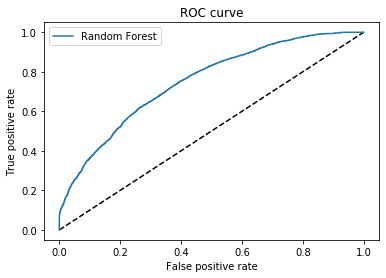

In [23]:
# Performance Metrics
y_prob = rf.predict_proba(X_train)[:, 1] #here we are only interested in True positive
y_pred = rf.predict(X_train)

p('Matrix training report for primary model & secondary model\n')

rs.report_matrix(actual_data = y_train, # we need to use our train data from train_test_split
                 prediction_data = y_pred, 
                 ROC = y_prob)

Matrix test report for primary model & secondary model

 Classification Report
              precision    recall  f1-score   support

         0.0       0.54      0.37      0.43      2280
         1.0       0.53      0.69      0.60      2340

    accuracy                           0.53      4620
   macro avg       0.53      0.53      0.52      4620
weighted avg       0.53      0.53      0.52      4620


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[ 833 1447]
 [ 720 1620]]

 Accuracy Score
0.530952380952381



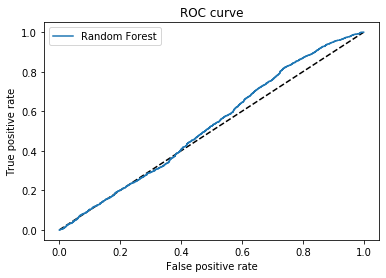

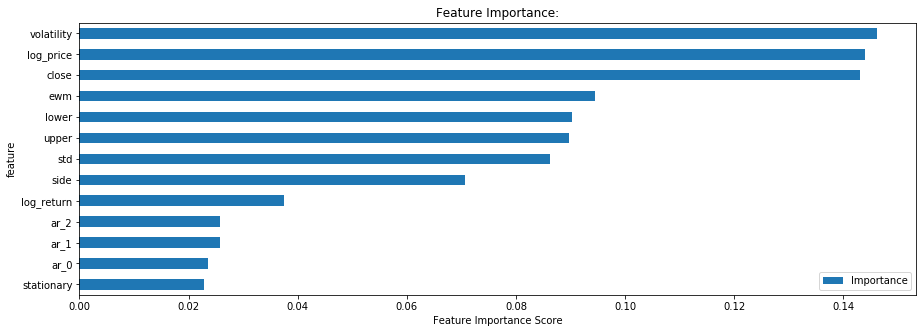

In [24]:
# Meta-label
# Performance Metrics
y_prob = rf.predict_proba(X_test)[:, 1] #here we are only interested in True positive
y_pred = rf.predict(X_test)

p('Matrix test report for primary model & secondary model\n')

rs.report_matrix(actual_data = y_test, 
                 prediction_data = y_pred, 
                 ROC = y_prob)

rs.feat_imp(rf, X)

In [ ]:
**Now we start to create only primary model**

In [25]:
events1 = rs.cs_filter(pri_dollar['close'], 
                    limit = pri_dollar['volatility'].mean())

vb1 = rs.vert_barrier(data = pri_dollar['close'], 
                 events = events1, 
                 period = 'days', 
                 freq = 1)

tb1 = rs.tri_barrier(data = pri_dollar['close'], 
                events = events1, 
                trgt = pri_dollar['volatility'], 
                min_req = 0.002, 
                num_threads = 3, 
                ptSl = [0,2], #change ptSl into [0,2]
                t1 = vb1, 
                side = None)

m_label1 = rs.meta_label(data = pri_dollar['close'],
                      events = tb1,
                      drop = 0.05) # take note we do not have a side hence we need to drop something

C:\Users\Wei_X\Desktop\Python\research\Labels\triple_barrier_method.py:75: UserWarning: Data and events index shape must be same, reindex data to fit events
  warnings.warn('Data and events index shape must be same, reindex data to fit events')
C:\Users\Wei_X\Desktop\Python\research\Labels\triple_barrier_method.py:112: UserWarning: Not Recommended: No side prediction provided
  warnings.warn('Not Recommended: No side prediction provided')


[                                             t1  sl  pt
2015-09-09 13:36:53.472 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:40:56.133 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:45:08.189 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:51:11.450 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 14:02:04.210 2015-09-10 14:05:19.003 NaT NaT
...                                         ...  ..  ..
2016-04-05 01:16:26.261 2016-04-06 02:45:07.823 NaT NaT
2016-04-05 06:02:04.305 2016-04-06 07:07:24.337 NaT NaT
2016-04-05 07:11:07.085 2016-04-06 08:05:23.022 NaT NaT
2016-04-05 07:37:56.273 2016-04-06 08:05:23.022 NaT NaT
2016-04-05 08:24:13.547 2016-04-06 09:05:34.702 NaT NaT

[5142 rows x 3 columns]] this out
[                                             t1  sl  pt
2015-09-09 13:36:53.472 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:40:56.133 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:45:08.189 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 13:51:11.450 2015-09-10 13:59:08.553 NaT NaT
2015-09-09 

 this out


2020-05-24 19:48:27.445715 100.0% _pt_sl_t1 done after 0.42 minutes. Remaining 0.0 minutes.


In [26]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=max_depth, 
                            n_estimators=n_estimators,
                            criterion='entropy', 
                            class_weight = None, #This will be cover in next few chapters
                            random_state=c_random_state)

X = pri_dollar.reindex(m_label1.index) # this dataframe only contain all our features
y = m_label1['bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Matrix training report for primary model only

 Classification Report
              precision    recall  f1-score   support

        -1.0       0.71      0.43      0.54      4965
         1.0       0.63      0.85      0.73      5748

    accuracy                           0.66     10713
   macro avg       0.67      0.64      0.63     10713
weighted avg       0.67      0.66      0.64     10713


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[2133 2832]
 [ 851 4897]]

 Accuracy Score
0.6562120787827873



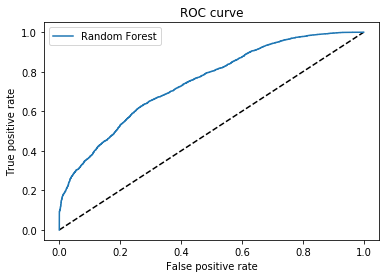

In [27]:
# Performance Metrics
y_prob = rf.predict_proba(X_train)[:, 1] #here we are only interested in True positive
y_pred = rf.predict(X_train)

p('Matrix training report for primary model only\n')

rs.report_matrix(actual_data = y_train, # we need to use our train data from train_test_split
                 prediction_data = y_pred, 
                 ROC = y_prob)

Matrix test report for primary model only

 Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.73      0.56      2027
         1.0       0.60      0.31      0.41      2565

    accuracy                           0.50      4592
   macro avg       0.53      0.52      0.49      4592
weighted avg       0.54      0.50      0.48      4592


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[1484  543]
 [1762  803]]

 Accuracy Score
0.4980400696864111



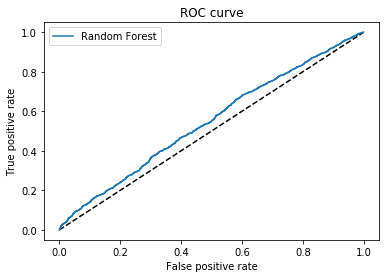

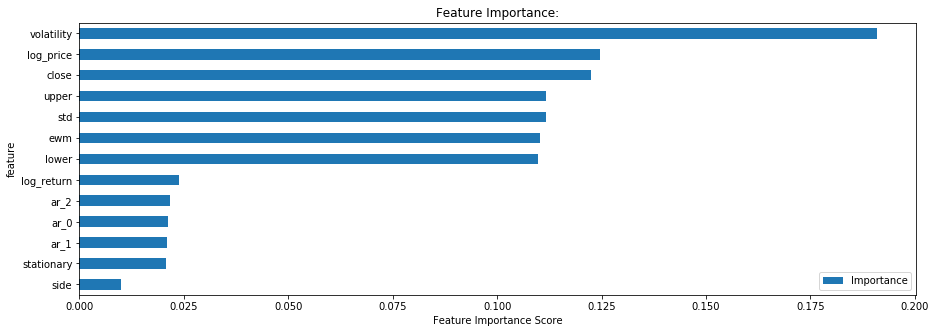

In [28]:
# Meta-label
# Performance Metrics
y_prob = rf.predict_proba(X_test)[:, 1] #here we are only interested in True positive
y_pred = rf.predict(X_test)

p('Matrix test report for primary model only\n')

rs.report_matrix(actual_data = y_test, 
                 prediction_data = y_pred, 
                 ROC = y_prob)

rs.feat_imp(rf, X)

## Based on our matrix report

The comparisons was made in ceteris paribus condition as much as possible.

All comparison will be made based on test data only, train data will be excluded.
    
### Accuracy comparison

**Accuracy is sum of True Positive and True Negative divided by overall set of items**

There is an improvement in accuracy rate when meta-label (Primary & secondary model score yield 0.53), with original yielding only 0.48.

Accuracy +0.05 improvement (10% increase) from the original, +0.0342 improvement (6.8% increase) from primary model only.

However, in order to correctly use this method. Dr Marco Lopez De Prado did mentioned the below:

>"First, we build a model that achieve high recall, even if precision is not particularly high.
>
> Second correct for low precision by applying meta-label to the positives predicted by the primary model." 
>
> Advances in Financial Machine Learning, page 52

However, for primary model only case. (-1,1) are consider price actions label, which in my opinion does not seem to work well with ML. But it does improve accuracy score by a small margin against original data with no labels. 

In our case, we filtered out labels that touched vertical barrier first from primary model only.

### F1 scores comparison
**Measures the efficiency of classifer (Harmonic mean of both precision and recall)**

Using both primary and secondary models to identify True Positive yields a score of 0.6 (for both long and short).

while using primary model only which gives 0.56 (for short) and 0.4 (for long).

F1 score +0.04 (7% increase/ short) and +0.2 (50% increase/ long) improvement, when compared against primary model only.

>"Meta-labeling is particularly helpful when you want to achieve higher F1-scores."
>
> Advances in Financial Machine Learning, page 52

### Other observations

<ins>Stationarity absolute return series</ins> as a optional key feature, does not seem relevant at all since the ML does not recognize it after log price absolute change. Hence it is lowly ranked in feature importance graph.

**For secondary model**

Crossing averages and volatility does seem to be at the top of the key features importance. This seems to say, ML model recognize that as key feature for predictions, while auto-correlation does not seem that important.

The ML model did realised, we were using those indicators as our primary models.

**For Primary model**

The ML model only recognize we were using volatility as our benchmark (tri_barrier func cs_filter as trgt), when we did not use any (0,1) meta-labels.

### Conclusion

To get a higher F1 score and better accuracy, quants should use both primary (To let it decide bet direction) while using a secondary model to decide bet size (To bet or not).

Stationarity is an important concept, especially to mean-reversion strategy. As Stationary series act as an anchor which the strategy will revert to eventually.

We will cover more with other examples regarding stationarity in the next chapter.